In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load configuration
with open("../config/config_notebooks.json", "r") as config_file:
    config = json.load(config_file)

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [2]:
a = config["base_color_palette"]
sns.set_palette(a)

base_model_palette = config["base_model_palette"]

base_models = config["base_model_list"]
path_to_regression_results = os.path.join(config["base_benchmark_folder"], "regression", "linear")

In [3]:
dfs = []
for file in base_models:
    print(file)

    dfs.append(pd.read_csv(os.path.join(path_to_regression_results, file, 'r2_scores.csv'), index_col=0))

df = pd.concat(dfs, axis=1)
df.columns = base_models

# df.index = [idx.replace("Texture", "Color")  if "color" in idx or "intensity" in idx else idx for idx in df.index]


uni
uni2
virchow
provgigapath
ctranspath
simclr


In [4]:
df.drop([idx for idx in df.index if idx.startswith('ExtraCell-Morph')], inplace=True)
# df.drop([idx for idx in df.index if idx.startswith('Nuclei-Composition')], inplace=True)

# df = df[(df >= 0).all(axis=1)]
df[df < 0] = 0

In [5]:
df

,uni,uni2,virchow,provgigapath,ctranspath,simclr
Nuclei-Morph_Area_mean,0.710304,0.706618,0.710562,0.718217,0.661757,0.635018
Nuclei-Morph_AreaBbox_mean,0.582204,0.576746,0.583045,0.586042,0.530577,0.501618
Nuclei-Morph_CellEccentricities_mean,0.560380,0.560260,0.597738,0.569185,0.524365,0.503253
Nuclei-Morph_Circularity_mean,0.470187,0.456662,0.495038,0.466186,0.423750,0.383642
Nuclei-Morph_Elongation_mean,0.587298,0.574101,0.614815,0.582153,0.553737,0.521677
...,...,...,...,...,...,...
WholePatch-Color_kurtosis_color_G,0.501928,0.497897,0.498802,0.519036,0.533924,0.453863
WholePatch-Color_kurtosis_color_B,0.649022,0.639521,0.658528,0.669422,0.663654,0.572094
WholePatch-Color_entropy_color_R,0.940545,0.929666,0.956988,0.952243,0.953109,0.899628
WholePatch-Color_entropy_color_G,0.930069,0.914491,0.942454,0.945143,0.946807,0.864146


In [6]:
df['feature_type'] = [idx.split('_')[0] for idx in df.index]

for feature_type in df['feature_type'].unique():
    print(f"############## {feature_type} ##############")
    for f in df[df['feature_type'] == feature_type].index:
        print('_'.join(f.split('_')[1:]))


############## Nuclei-Morph ##############
Area_mean
AreaBbox_mean
CellEccentricities_mean
Circularity_mean
Elongation_mean
Extent_mean
MajorAxisLength_mean
MinorAxisLength_mean
Perimeter_mean
Solidity_mean
CurvMean_mean
CurvStd_mean
CurvMax_mean
CurvMin_mean
Area_std
AreaBbox_std
CellEccentricities_std
Circularity_std
Elongation_std
Extent_std
MajorAxisLength_std
MinorAxisLength_std
Perimeter_std
Solidity_std
CurvMean_std
CurvStd_std
CurvMax_std
CurvMin_std
zernike_moment_1_mean
zernike_moment_1_std
zernike_moment_2_mean
zernike_moment_2_std
zernike_moment_3_mean
zernike_moment_3_std
zernike_moment_4_mean
zernike_moment_4_std
zernike_moment_5_mean
zernike_moment_5_std
zernike_moment_6_mean
zernike_moment_6_std
zernike_moment_7_mean
zernike_moment_7_std
zernike_moment_8_mean
zernike_moment_8_std
zernike_moment_9_mean
zernike_moment_9_std
zernike_moment_10_mean
zernike_moment_10_std
zernike_moment_11_mean
zernike_moment_11_std
zernike_moment_12_mean
zernike_moment_12_std
############## 

In [7]:
df.loc[[idx for idx in df.index if idx.startswith('Nuclei-Composition')]]

,uni,uni2,virchow,provgigapath,ctranspath,simclr,feature_type
Nuclei-Composition_number_of_cells,0.921386,0.917346,0.926707,0.925060,0.920784,0.913191,Nuclei-Composition
Nuclei-Composition_total_cell_density,0.921386,0.917346,0.926707,0.925060,0.920784,0.913191,Nuclei-Composition
Nuclei-Composition_prop_of_T_cells,0.716624,0.718789,0.716751,0.724160,0.705641,0.694036,Nuclei-Composition
Nuclei-Composition_density_of_T_cells,0.698032,0.702470,0.701194,0.706930,0.696448,0.694164,Nuclei-Composition
Nuclei-Composition_prop_of_I_cells,0.699643,0.700881,0.702530,0.702697,0.678227,0.646899,Nuclei-Composition
Nuclei-Composition_density_of_I_cells,0.849823,0.850415,0.859819,0.857140,0.842521,0.821573,Nuclei-Composition
Nuclei-Composition_prop_of_S_cells,0.761089,0.758664,0.762945,0.756070,0.739445,0.729142,Nuclei-Composition
Nuclei-Composition_density_of_S_cells,0.641759,0.634637,0.644982,0.635955,0.627580,0.606762,Nuclei-Composition
Nuclei-Composition_prop_of_N_cells,0.249699,0.257567,0.248883,0.267586,0.220941,0.210420,Nuclei-Composition
Nuclei-Composition_density_of_N_cells,0.285387,0.306992,0.290563,0.324047,0.253590,0.243838,Nuclei-Composition


In [8]:
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon, levene
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from itertools import combinations
from statannotations.Annotator import Annotator

def plot_boxplot_significance(df, x, y, log_scale=False, stripplot=True, palette=None, fontsize=12, showfliers=True,
                              stat='t-test', pairs=None, p_values=None, boxplot=True, 
                              ylim=None):
    """
    Plot boxplots with significance annotations.

    Args:
        df (pandas.DataFrame): The dataframe containing the data.
        x (str): The column name for the x-axis.
        y (str): The column name for the y-axis.
        log_scale (bool, optional): Whether to use a logarithmic scale for the y-axis. Defaults to False.
    """

    if pairs is None or p_values is None:
        pairs = list(combinations(list(df[x].unique()), 2))
        p_values = []
        for p1, p2 in pairs:
            if stat == 't-test':
                p_values.append(
                    ttest_ind(
                        list(df[df[x] == p1][y].values),
                        list(df[df[x] == p2][y].values),
                        equal_var=False,
                        alternative="two-sided",
                        nan_policy='omit')[1])
            elif stat == 'mannwhitneyu':
                p_values.append(
                    mannwhitneyu(
                        list(df[df[x] == p1][y].values),
                        list(df[df[x] == p2][y].values),
                        alternative="two-sided")[1])
            elif stat == 'wilcoxon':
                p_values.append(
                    wilcoxon(
                        list(df[df[x] == p1][y].values),
                        list(df[df[x] == p2][y].values),
                        alternative="two-sided")[1])
            elif stat == 'levene':
                p_values.append(
                    levene(
                        list(df[df[x] == p1][y].values),
                        list(df[df[x] == p2][y].values))[1])
            else:
                raise ValueError(f"Stat test {stat} not supported")
            
    formatted_pvalues = [f"P={pvalue:.2e}" for pvalue in p_values]

    plotting_parameters = {"data": df, "x": x, "y": y, "linewidth": 2.3, 'palette': palette}

    if boxplot:
        ax = sns.boxplot(**plotting_parameters, showfliers=showfliers)
    else:
        ax = sns.violinplot(**plotting_parameters)
    if stripplot:
        sns.stripplot(**plotting_parameters, ax=ax, hue=x)

    if log_scale:
        ax.set_yscale('log')

    if ylim is not None:
        ax.set_ylim(ylim)

    annotator = Annotator(ax, pairs, **plotting_parameters);
    annotator.configure(fontsize=fontsize);

    annotator.set_custom_annotations(formatted_pvalues);
    annotator.annotate();
    plt.ylabel(y)
    sns.despine()
    plt.xticks(rotation=30)

In [9]:
df_melted = pd.melt(df[base_models], var_name='Model', value_name='R2 score')
df_melted.index = list(df[base_models].index) * len(df[base_models].columns)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uni vs. uni2: P=8.20e-01
uni2 vs. virchow: P=7.88e-01
virchow vs. provgigapath: P=9.88e-01
provgigapath vs. ctranspath: P=7.10e-01
ctranspath vs. simclr: P=2.17e-01
uni vs. virchow: P=9.68e-01
uni2 vs. provgigapath: P=8.01e-01
virchow vs. ctranspath: P=6.97e-01
provgigapath vs. simclr: P=1.07e-01
uni vs. provgigapath: P=9.80e-01
uni2 vs. ctranspath: P=9.01e-01
virchow vs. simclr: P=1.01e-01
uni vs. ctranspath: P=7.28e-01
uni2 vs. simclr: P=1.69e-01
uni vs. simclr: P=1.11e-01


Text(0.5, 1.0, 'Linear regression R2 scores')

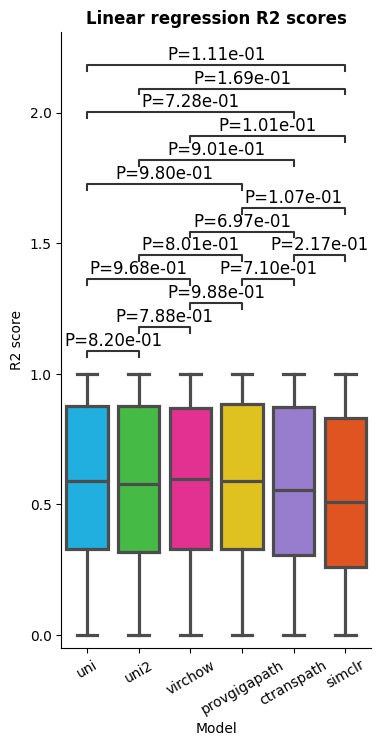

In [10]:
plt.figure(figsize=(4, 8))
plot_boxplot_significance(df_melted, 
                          x='Model', 
                          y='R2 score', 
                          log_scale=False, 
                          stripplot=False, 
                          fontsize=12, 
                          showfliers=False, 
                          stat='t-test', 
                          pairs=None, 
                          p_values=None, 
                          boxplot=True)

plt.title('Linear regression R2 scores', weight='bold')
#plt.savefig("../Figures/Fig1/hancrafted_features_r2_overall_with_pval.pdf", bbox_inches='tight')

In [11]:
df_melted

,Model,R2 score
Nuclei-Morph_Area_mean,uni,0.710304
Nuclei-Morph_AreaBbox_mean,uni,0.582204
Nuclei-Morph_CellEccentricities_mean,uni,0.560380
Nuclei-Morph_Circularity_mean,uni,0.470187
Nuclei-Morph_Elongation_mean,uni,0.587298
...,...,...
WholePatch-Color_kurtosis_color_G,simclr,0.453863
WholePatch-Color_kurtosis_color_B,simclr,0.572094
WholePatch-Color_entropy_color_R,simclr,0.899628
WholePatch-Color_entropy_color_G,simclr,0.864146


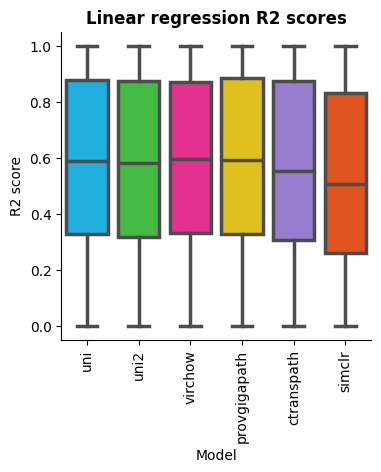

In [12]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=df_melted, x='Model', y='R2 score', showfliers=False, palette=base_model_palette,
            linewidth=2.5)
sns.despine()
plt.title('Linear regression R2 scores', weight='bold')
plt.xticks(rotation=90)
plt.savefig(os.path.join(config["figures_folder"], "Figure2/handcrafted_features_r2_overall.pdf"), bbox_inches='tight')

In [13]:
import json 
from scipy.stats import pearsonr, spearmanr

with open(os.path.join(config['base_benchmark_folder'], 'shannon_entropy', "shannon_entropy_512_comps_raw_rescaled.json")) as f:
    shannon_entropy = json.load(f)

df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])

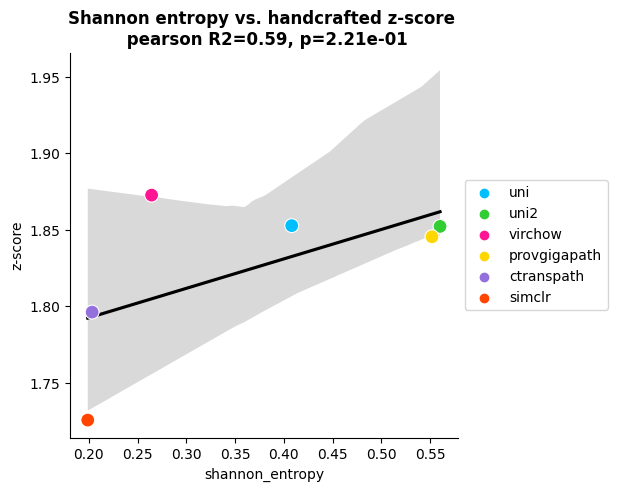

In [14]:
base_model_palette = config["base_model_palette"]
plt.figure(figsize=(5, 5))

df_ = pd.DataFrame(df.mean()/df.std())
df_.columns = ['z-score']
df_ = df_.merge(df_shannon, left_index=True, right_index=True)

s, p = pearsonr(df_['shannon_entropy'], df_['z-score'])

sns.regplot(x='shannon_entropy', y='z-score', data=df_, color='black')
sns.scatterplot(x='shannon_entropy', y='z-score', data=df_, hue=df_.index, palette=base_model_palette, zorder=2, s=100)
sns.despine()
plt.title(f"Shannon entropy vs. handcrafted z-score \n pearson R2={s:.2f}, p={p:.2e}", weight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(config["figures_folder"], "Figure2/handcrafted_zscore_vs_shannon.pdf"), bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uni vs. uni2: P=9.17e-01
uni2 vs. virchow: P=7.74e-01
virchow vs. provgigapath: P=8.88e-01
provgigapath vs. ctranspath: P=5.43e-01
ctranspath vs. simclr: P=6.13e-01
uni vs. virchow: P=8.54e-01
uni2 vs. provgigapath: P=8.84e-01
virchow vs. ctranspath: P=4.51e-01
provgigapath vs. simclr: P=2.70e-01
uni vs. provgigapath: P=9.67e-01
uni2 vs. ctranspath: P=6.44e-01
virchow vs. simclr: P=2.11e-01
uni vs. ctranspath: P=5.70e-01
uni2 vs. simclr: P=3.37e-01
uni vs. simclr: P=2.86e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uni vs. uni2: P=8.94e-01
uni2 vs. virchow: P=9.14e-01
virchow vs. provgigapath: P=9.29e-01
provgigapath vs. ctranspath: P=8.77e-01
ctranspath vs. simclr: P=3.

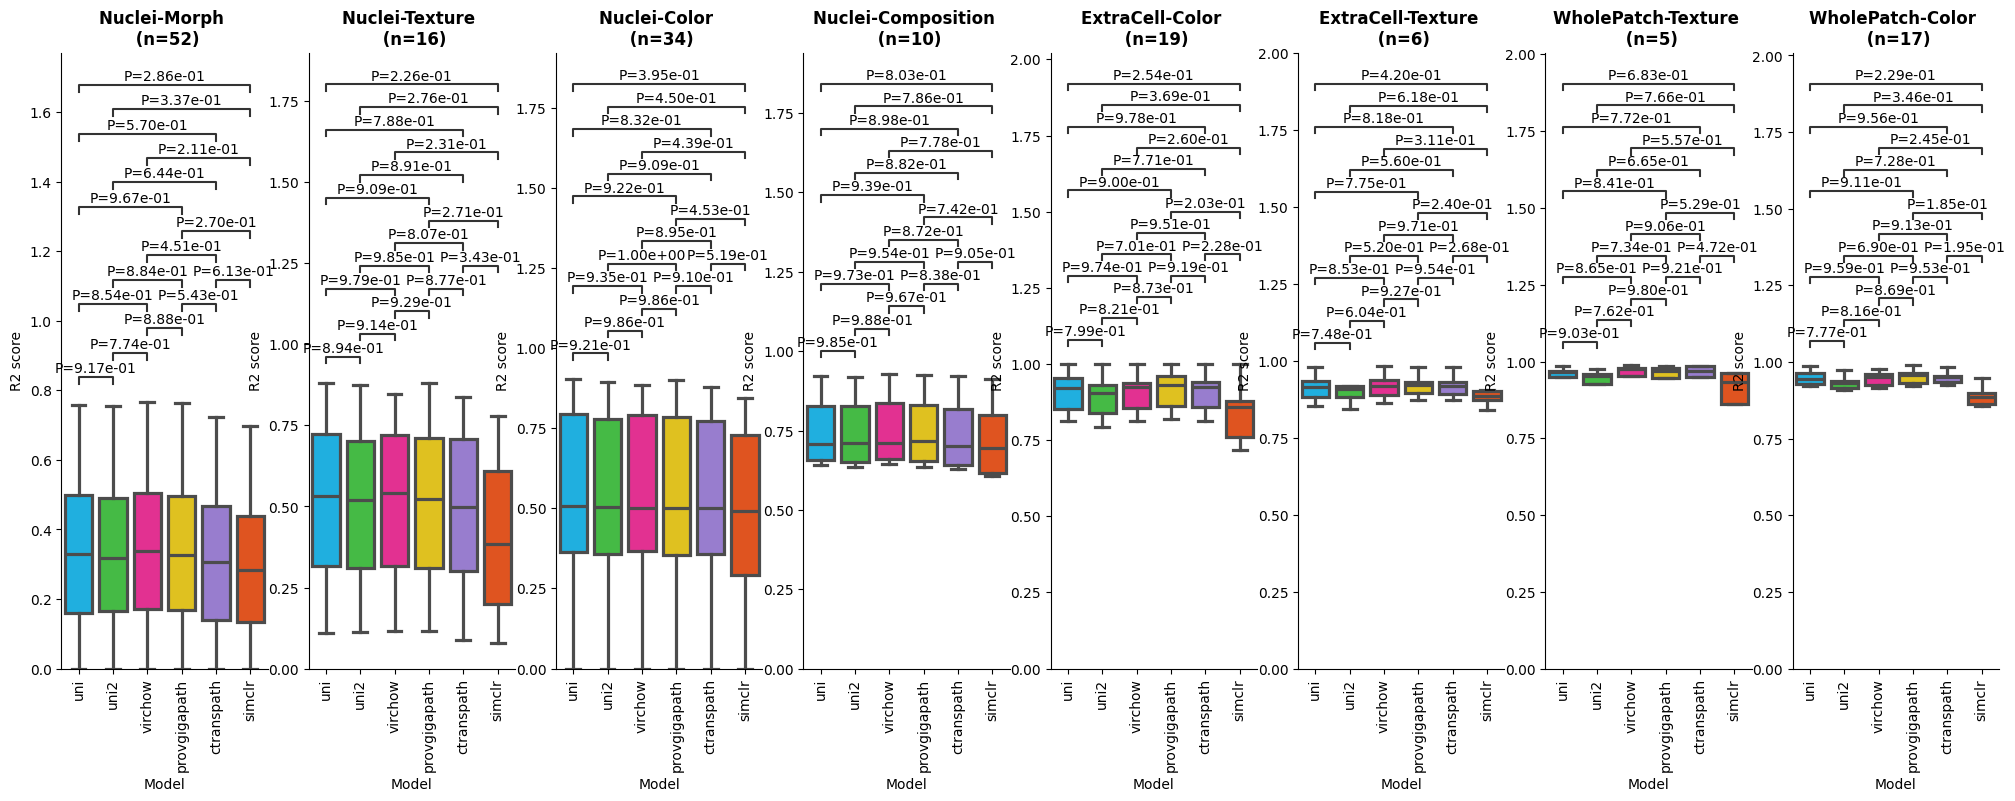

In [15]:
df_melted['feature_type'] = [idx.split("_")[0] for idx in df_melted.index]
plt.figure(figsize=(25, 8))
for feature in df_melted['feature_type'].unique():
    plt.subplot(1, 8, list(df_melted['feature_type'].unique()).index(feature) + 1)
    plot_boxplot_significance(df_melted[df_melted['feature_type'] == feature], 
                              x='Model', 
                              y='R2 score', 
                              log_scale=False, 
                              stripplot=False, 
                              fontsize=10, 
                              showfliers=False, 
                              stat='t-test', 
                              pairs=None, 
                              p_values=None, 
                              boxplot=True,
                              ylim=(0,1))
    plt.title(f"{feature} \n (n={int(len(df_melted[df_melted['feature_type'] == feature])/len(base_models))})", weight='bold')
    plt.xticks(rotation=90)


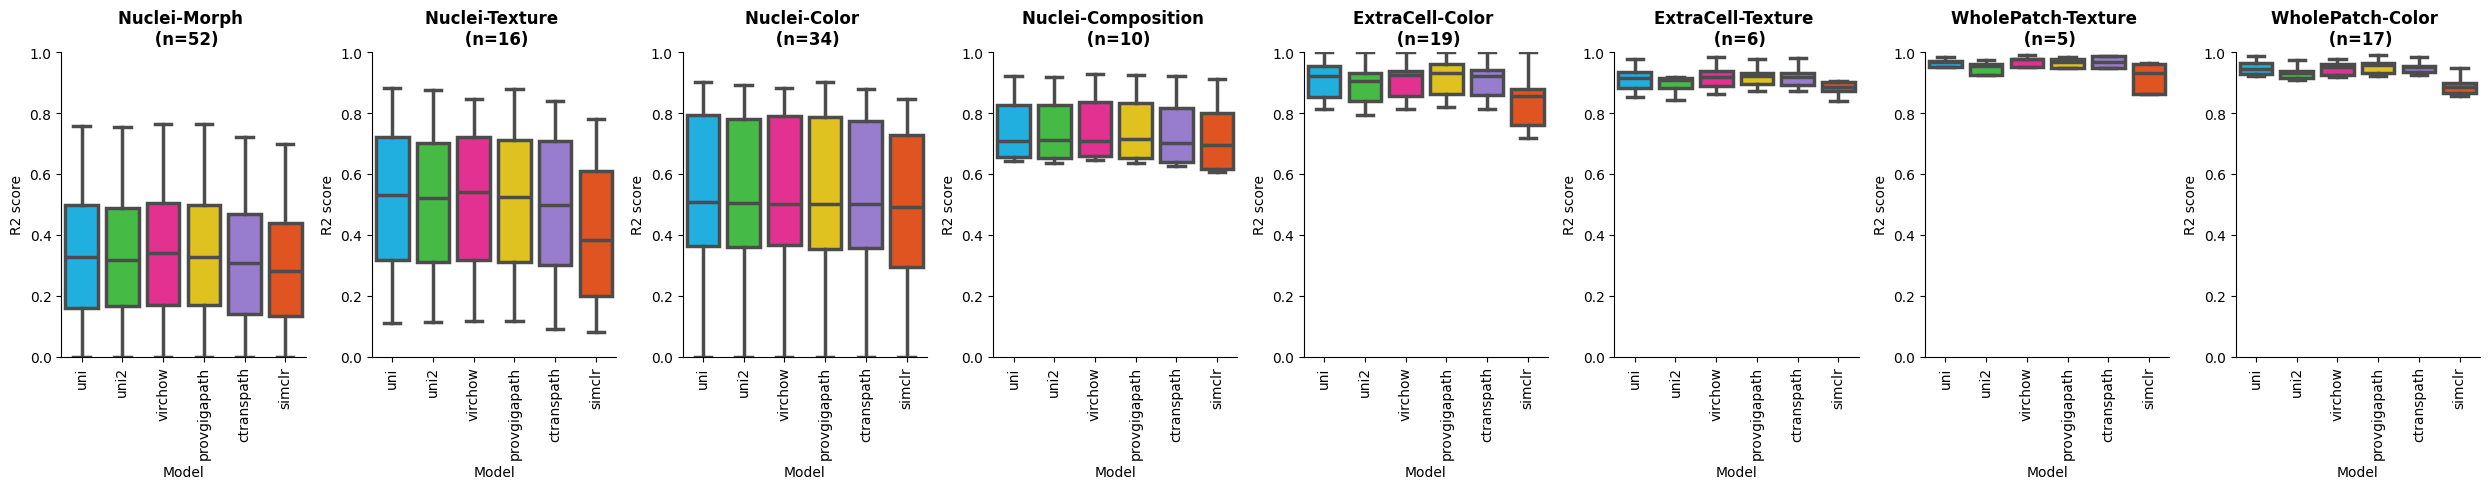

In [16]:
plt.figure(figsize=(25, 5))
for feature in df_melted['feature_type'].unique():
    plt.subplot(1, 8, list(df_melted['feature_type'].unique()).index(feature) + 1)
    sns.boxplot(df_melted[df_melted['feature_type'] == feature], 
                              x='Model', 
                              y='R2 score', 
                              showfliers=False, 
                              palette=base_model_palette,
                              linewidth=2.5)
    
    sns.despine()
    plt.title(f"{feature} \n (n={int(len(df_melted[df_melted['feature_type'] == feature])/len(base_models))})", weight='bold')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    
plt.tight_layout()
plt.savefig(os.path.join(config["figures_folder"], "Figure3/handcrafted_features_r2_per_feature.pdf"), bbox_inches='tight')

                                       Model  R2 score  feature_type
Nuclei-Morph_Area_mean                   uni  0.710304  Nuclei-Morph
Nuclei-Morph_AreaBbox_mean               uni  0.582204  Nuclei-Morph
Nuclei-Morph_CellEccentricities_mean     uni  0.560380  Nuclei-Morph
Nuclei-Morph_Circularity_mean            uni  0.470187  Nuclei-Morph
Nuclei-Morph_Elongation_mean             uni  0.587298  Nuclei-Morph
...                                      ...       ...           ...
Nuclei-Morph_zernike_moment_10_std    simclr  0.055896  Nuclei-Morph
Nuclei-Morph_zernike_moment_11_mean   simclr  0.234930  Nuclei-Morph
Nuclei-Morph_zernike_moment_11_std    simclr  0.139735  Nuclei-Morph
Nuclei-Morph_zernike_moment_12_mean   simclr  0.452076  Nuclei-Morph
Nuclei-Morph_zernike_moment_12_std    simclr  0.263671  Nuclei-Morph

[312 rows x 3 columns]
Error plotting clustermap
                                    Model  R2 score    feature_type
Nuclei-Texture_ASM_mean               uni  0.589742  N

<Figure size 400x800 with 0 Axes>

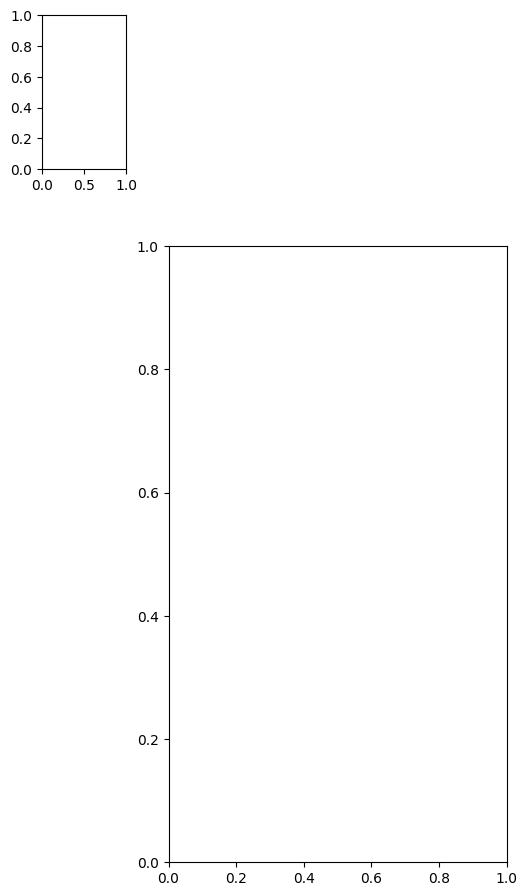

<Figure size 400x800 with 0 Axes>

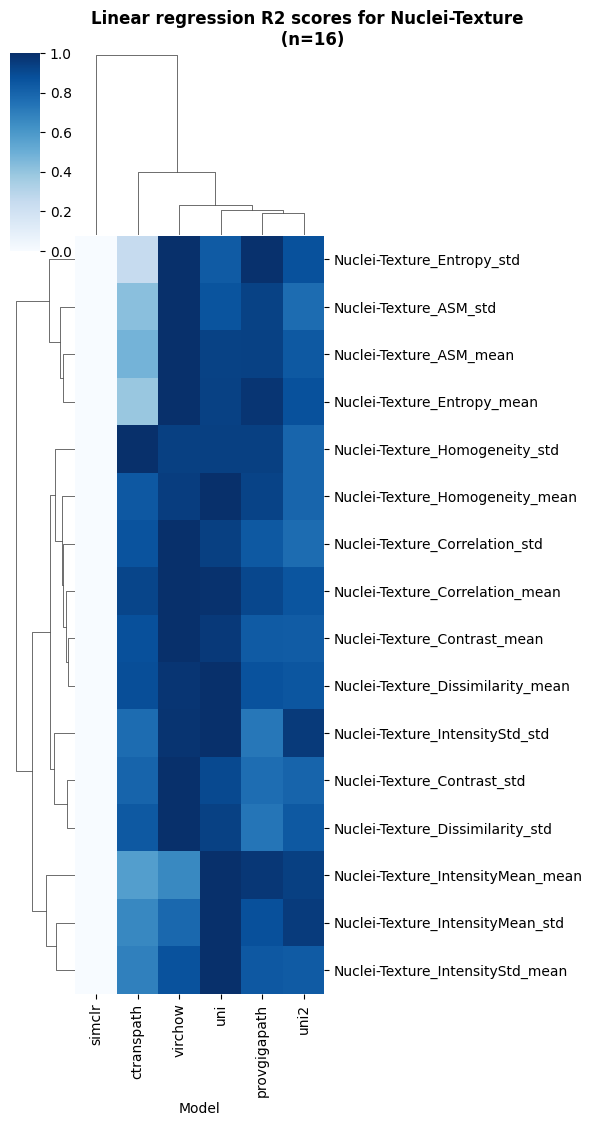

<Figure size 400x800 with 0 Axes>

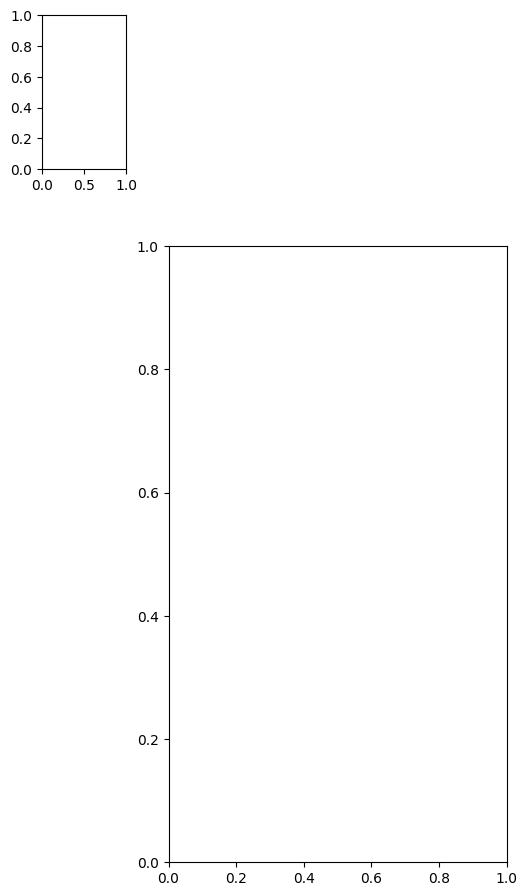

<Figure size 400x800 with 0 Axes>

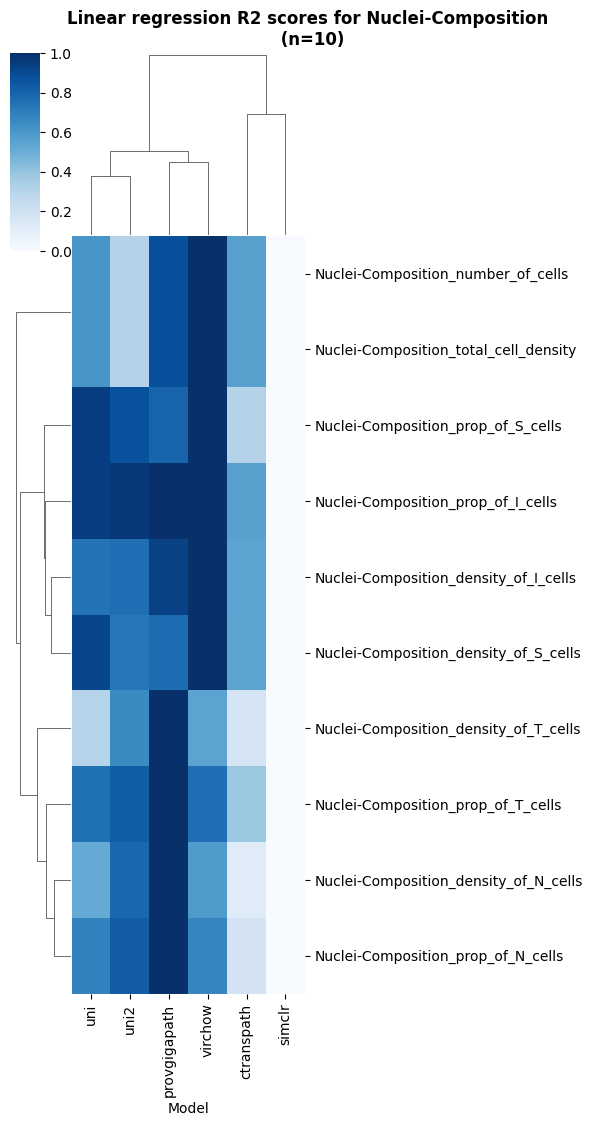

<Figure size 400x800 with 0 Axes>

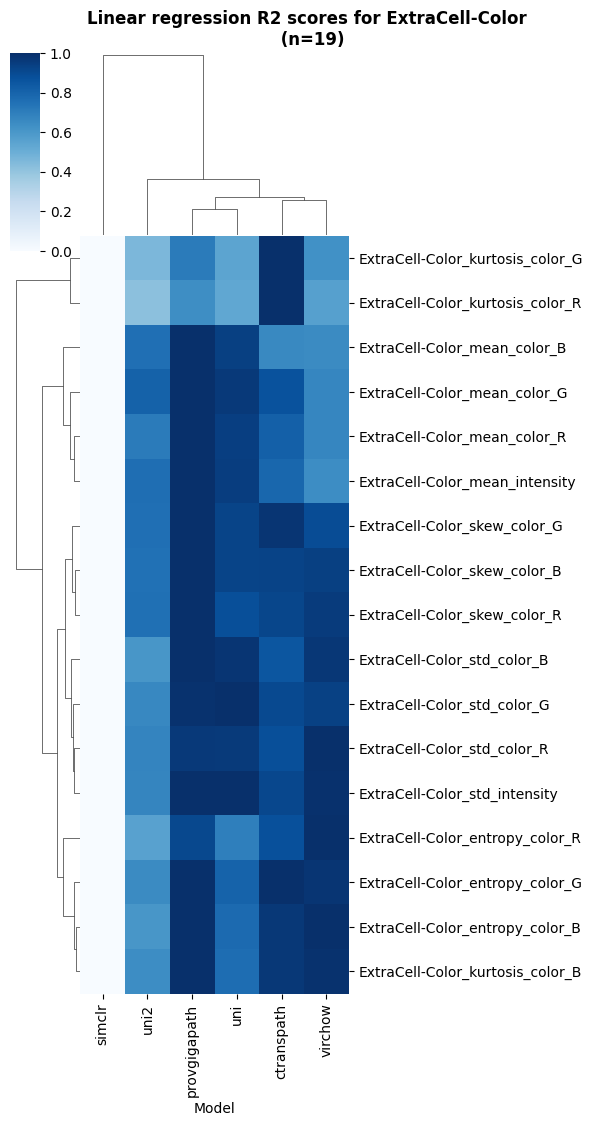

<Figure size 400x800 with 0 Axes>

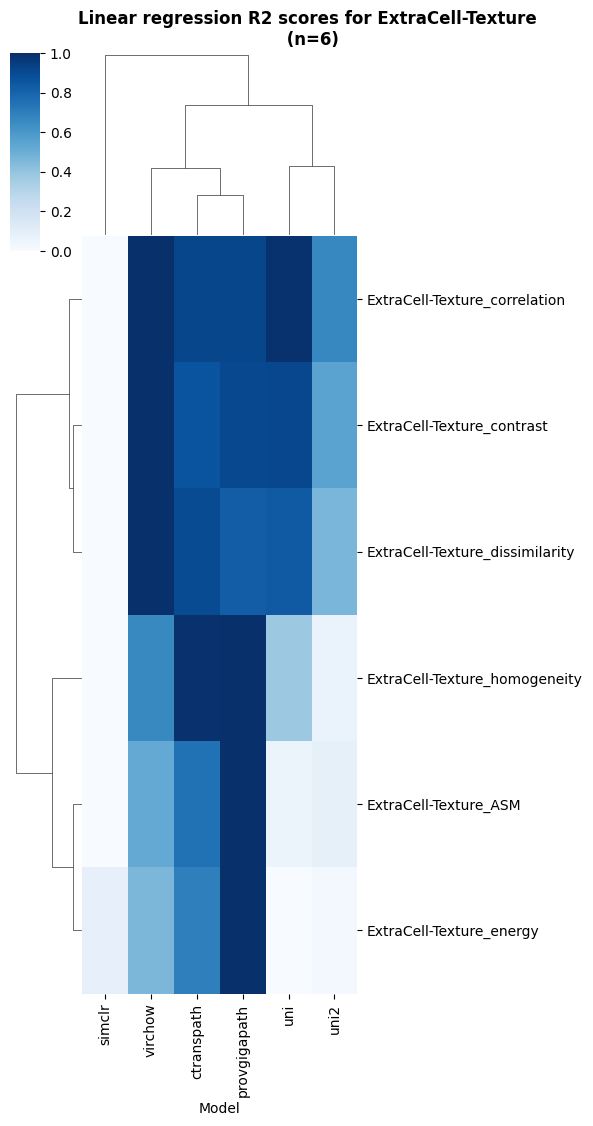

<Figure size 400x800 with 0 Axes>

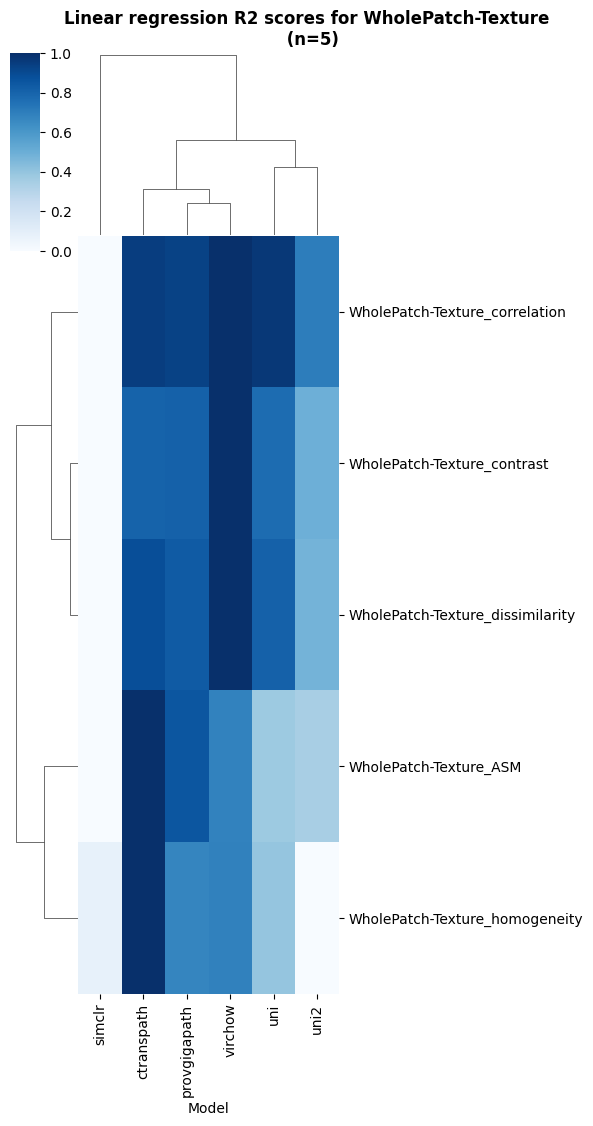

<Figure size 400x800 with 0 Axes>

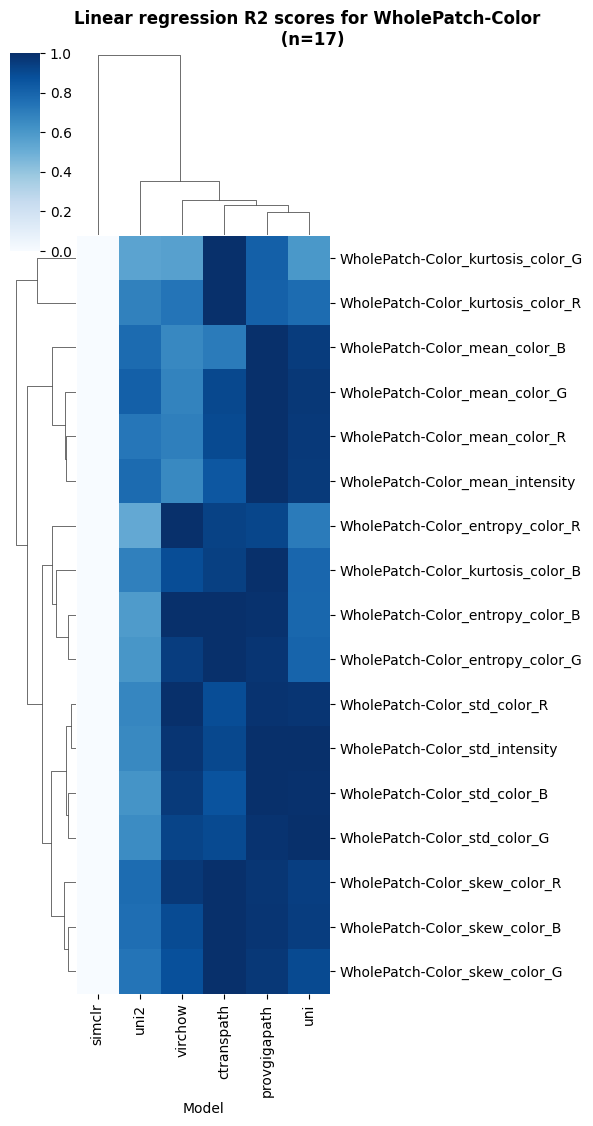

In [17]:
from sklearn.preprocessing import StandardScaler

for feature in df_melted['feature_type'].unique():
    plt.figure(figsize=(4, 8))
    sub_df = df_melted[df_melted['feature_type'] == feature]
    print(sub_df)
    
    # Remove infinite values in the dataframe
    sub_df = sub_df.replace([np.inf, -np.inf], np.nan)
    
    # Drop rows with NaN values
    sub_df = sub_df.dropna()
    
    # Pivot the DataFrame
    pivot_df = sub_df.pivot(columns='Model', values='R2 score')
    
    # Check for non-finite values in the pivoted DataFrame
    if np.any(~np.isfinite(pivot_df.values)):
        print("Pivoted DataFrame contains non-finite values. Replacing them with the maximum finite value.")
        pivot_df = pivot_df.applymap(lambda x: np.nanmax(pivot_df.values[np.isfinite(pivot_df.values)]) if not np.isfinite(x) else x)
    if feature == "ExtraCell-Color":
        pivot_df.drop(["ExtraCell-Color_mean_transparency", "ExtraCell-Color_std_transparency"], inplace=True)
    try:
        sns.clustermap(pivot_df, 
                    cmap='Blues', 
                    figsize=(6, 11), 
                    method='average', 
                    metric='euclidean', 
                    standard_scale=0, 
                    row_cluster=True, 
                    col_cluster=True,
                    yticklabels=True)
        plt.title(f"Linear regression R2 scores for {feature} \n (n={int(len(df_melted[df_melted['feature_type'] == feature])/len(base_models))})", weight='bold', x=10)
    except:
        print("Error plotting clustermap")
        continue
    
    plt.savefig(os.path.join(config["figures_folder"], f"Figure2/handcrafted_features_heatmap_r2_{feature}.pdf"), bbox_inches='tight')

                                       Model  R2 score  feature_type
Nuclei-Morph_Area_mean                   uni  0.710304  Nuclei-Morph
Nuclei-Morph_AreaBbox_mean               uni  0.582204  Nuclei-Morph
Nuclei-Morph_CellEccentricities_mean     uni  0.560380  Nuclei-Morph
Nuclei-Morph_Circularity_mean            uni  0.470187  Nuclei-Morph
Nuclei-Morph_Elongation_mean             uni  0.587298  Nuclei-Morph
...                                      ...       ...           ...
Nuclei-Morph_zernike_moment_10_std    simclr  0.055896  Nuclei-Morph
Nuclei-Morph_zernike_moment_11_mean   simclr  0.234930  Nuclei-Morph
Nuclei-Morph_zernike_moment_11_std    simclr  0.139735  Nuclei-Morph
Nuclei-Morph_zernike_moment_12_mean   simclr  0.452076  Nuclei-Morph
Nuclei-Morph_zernike_moment_12_std    simclr  0.263671  Nuclei-Morph

[312 rows x 3 columns]
Error plotting clustermap
                                    Model  R2 score    feature_type
Nuclei-Texture_ASM_mean               uni  0.589742  N

<Figure size 400x800 with 0 Axes>

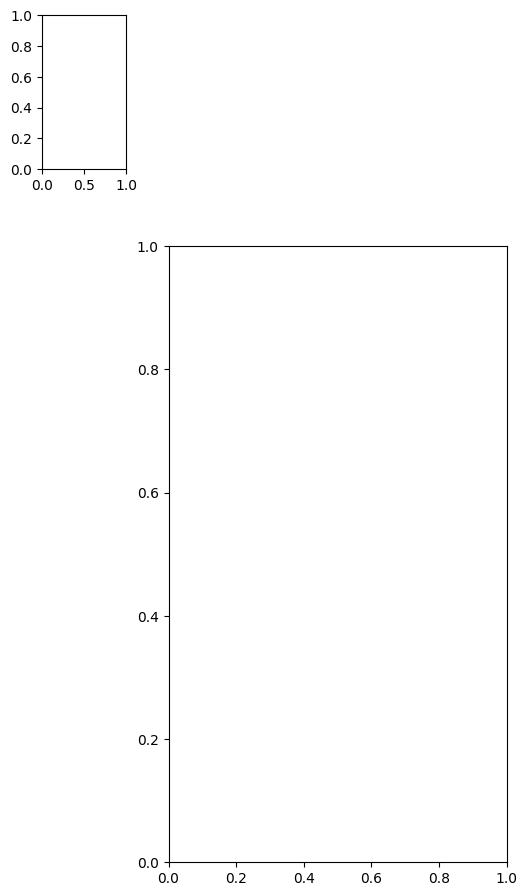

<Figure size 400x800 with 0 Axes>

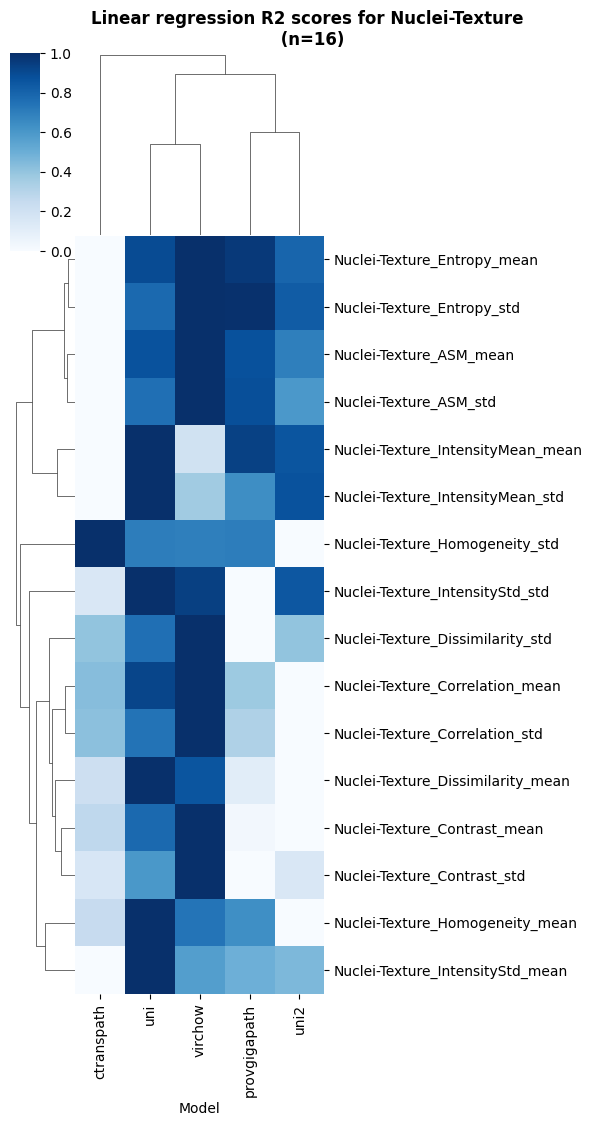

<Figure size 400x800 with 0 Axes>

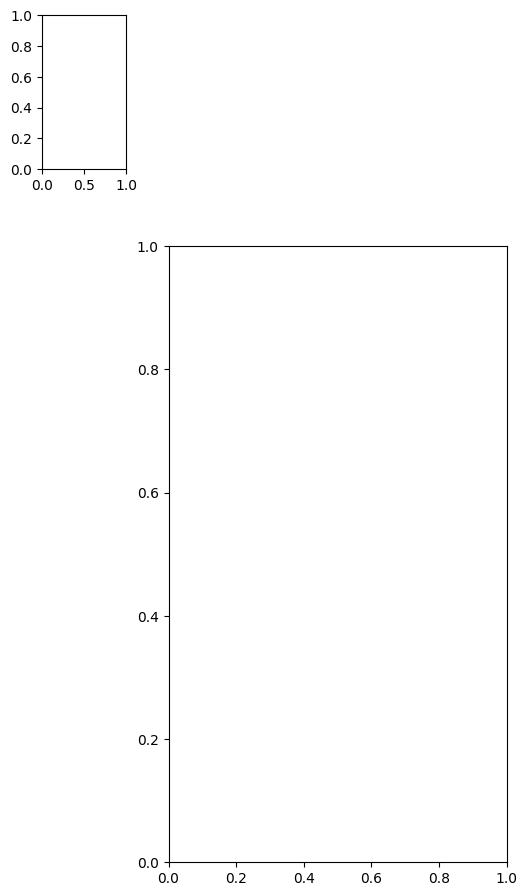

<Figure size 400x800 with 0 Axes>

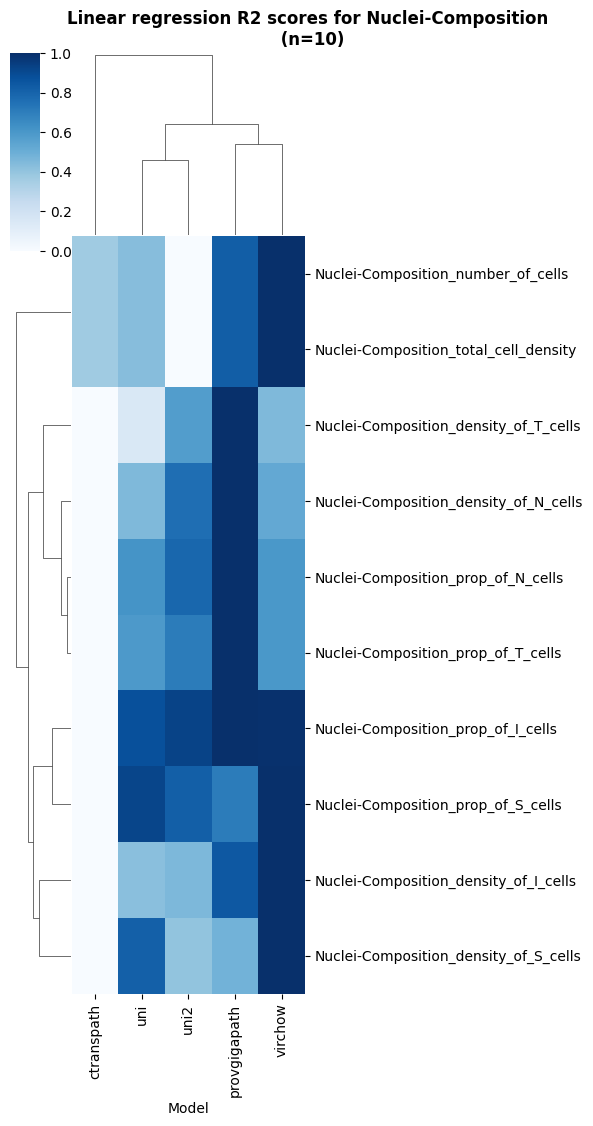

<Figure size 400x800 with 0 Axes>

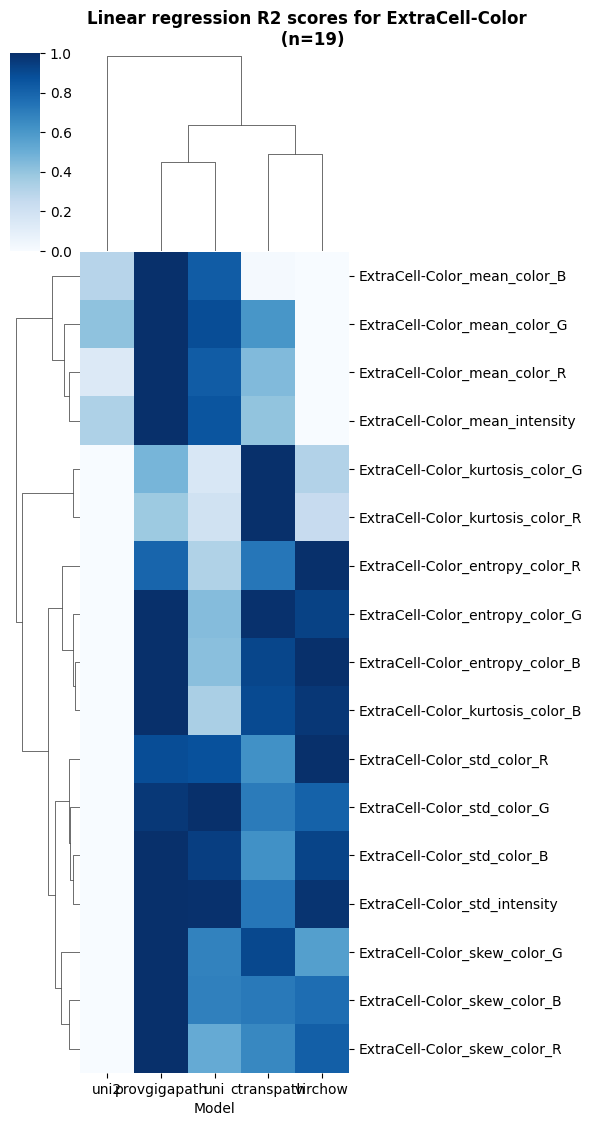

<Figure size 400x800 with 0 Axes>

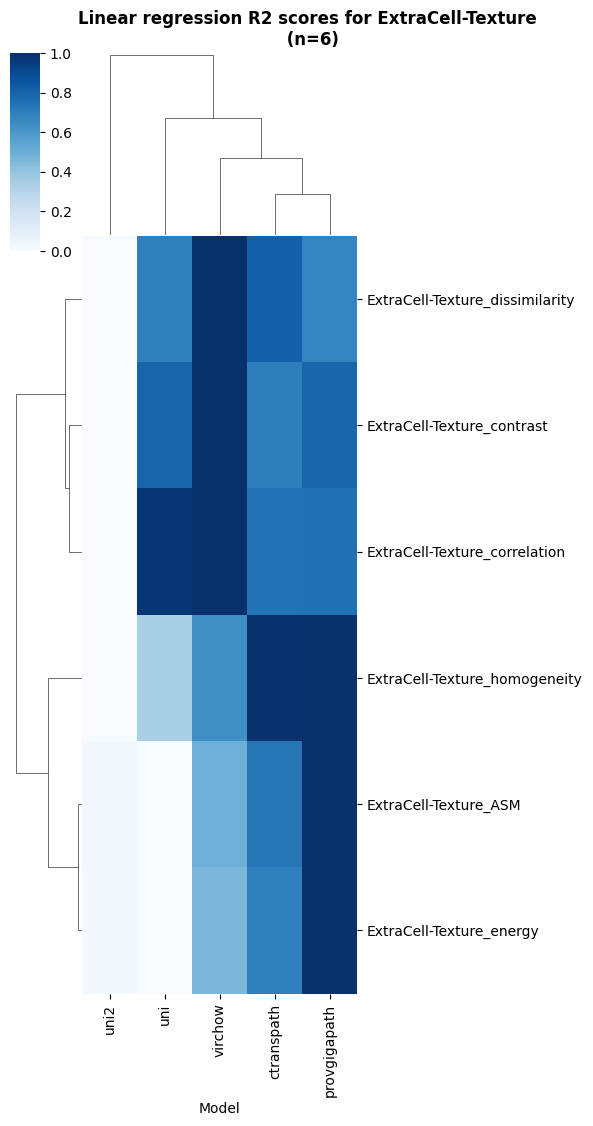

<Figure size 400x800 with 0 Axes>

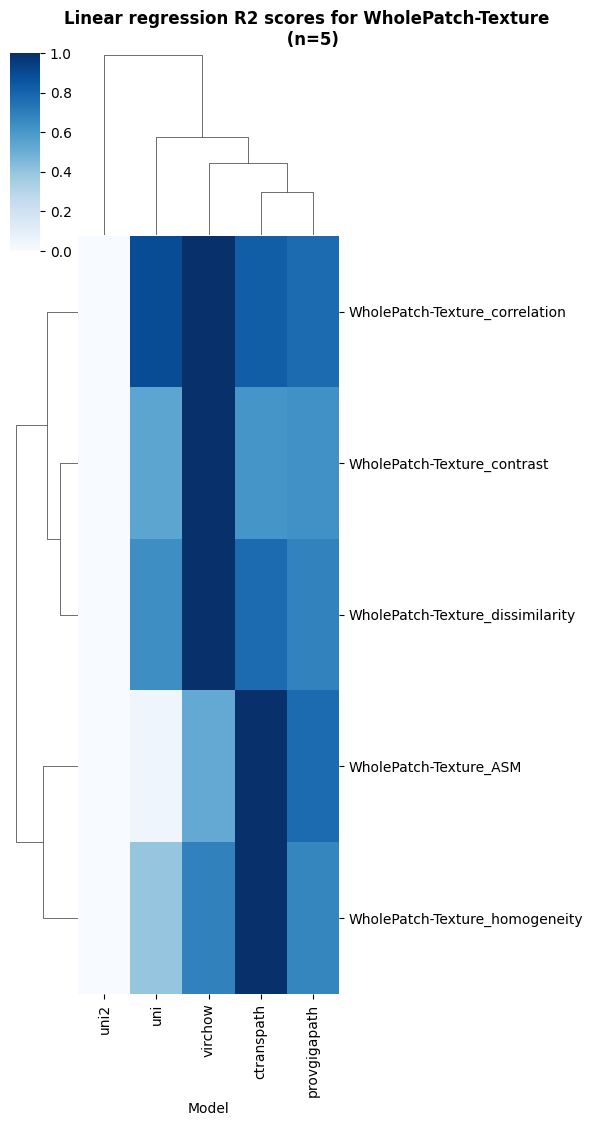

<Figure size 400x800 with 0 Axes>

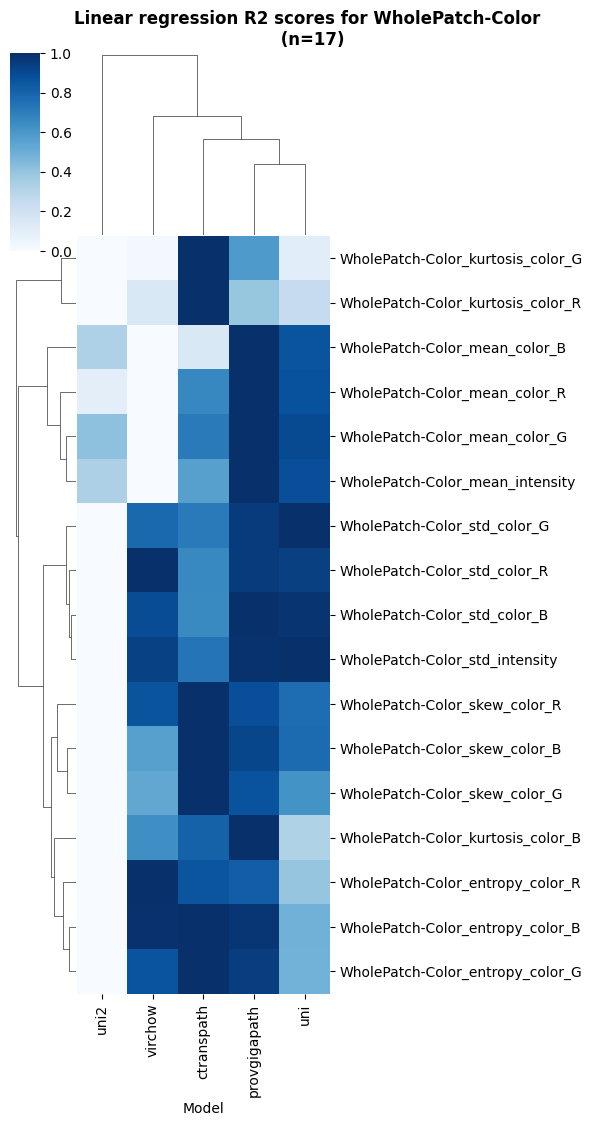

In [18]:
for feature in df_melted['feature_type'].unique():
    plt.figure(figsize=(4, 8))
    sub_df = df_melted[df_melted['feature_type'] == feature]
    print(sub_df)
    
    # Remove infinite values in the dataframe
    sub_df = sub_df.replace([np.inf, -np.inf], np.nan)
    
    # Drop rows with NaN values
    sub_df = sub_df.dropna()
    
    # Pivot the DataFrame
    pivot_df = sub_df.pivot(columns='Model', values='R2 score')
    
    pivot_df.drop(['simclr'], axis=1, inplace=True)
    # Check for non-finite values in the pivoted DataFrame
    if np.any(~np.isfinite(pivot_df.values)):
        print("Pivoted DataFrame contains non-finite values. Replacing them with the maximum finite value.")
        pivot_df = pivot_df.applymap(lambda x: np.nanmax(pivot_df.values[np.isfinite(pivot_df.values)]) if not np.isfinite(x) else x)
    if feature == "ExtraCell-Color":
        pivot_df.drop(["ExtraCell-Color_mean_transparency", "ExtraCell-Color_std_transparency"], inplace=True)
    try:
        sns.clustermap(pivot_df, 
                    cmap='Blues', 
                    figsize=(6, 11), 
                    method='average', 
                    metric='euclidean', 
                    standard_scale=0, 
                    row_cluster=True, 
                    col_cluster=True,
                    yticklabels=True)
        plt.title(f"Linear regression R2 scores for {feature} \n (n={int(len(df_melted[df_melted['feature_type'] == feature])/len(base_models))})", weight='bold', x=10)
    except:
        print("Error plotting clustermap")
        continue
    
    plt.savefig(os.path.join(config["figures_folder"], f"Figure3/handcrafted_features_heatmap_r2_{feature}_without_simclr.pdf"), bbox_inches='tight')

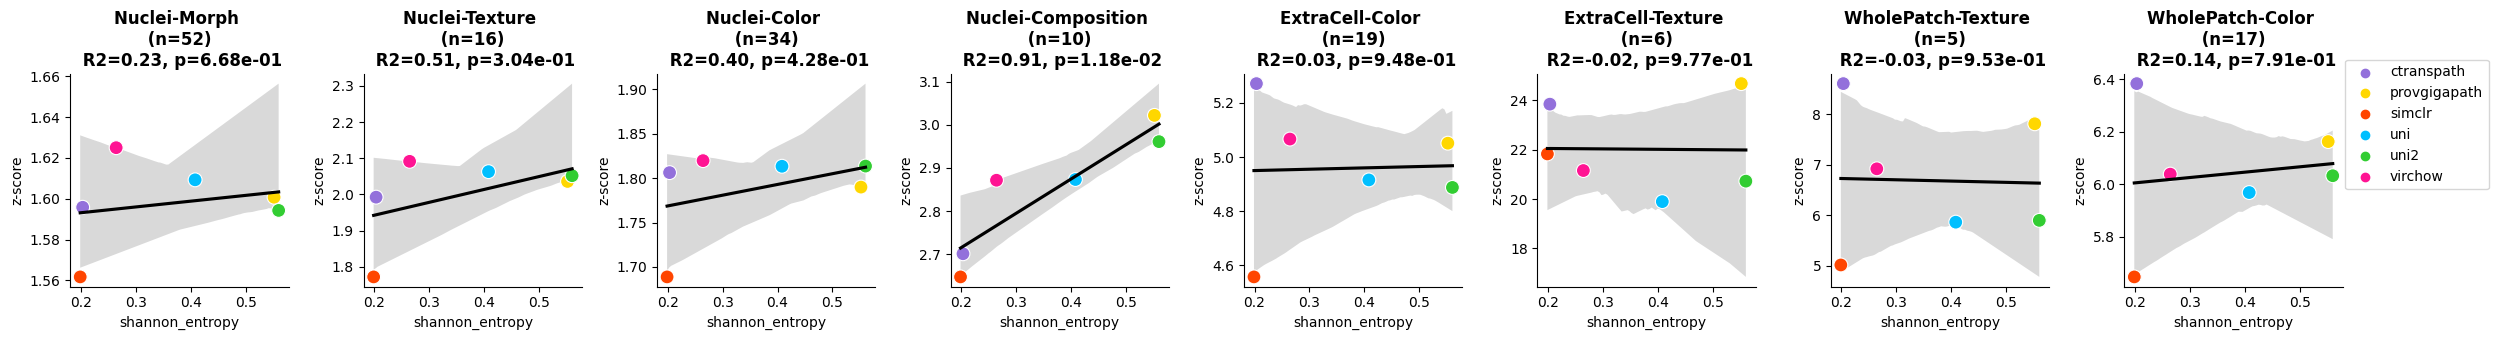

In [19]:
base_model_palette = config["base_model_palette"]
plt.figure(figsize=(25, 3.5))

for feature in df_melted['feature_type'].unique():
    plt.subplot(1, 8, list(df_melted['feature_type'].unique()).index(feature) + 1)
    sub_df = df_melted[df_melted['feature_type'] == feature].pivot(columns='Model', values='R2 score')
    df_ = pd.DataFrame(sub_df.mean()/sub_df.std())
    df_.columns = ['z-score']
    df_ = df_.merge(df_shannon, left_index=True, right_index=True)

    s, p = pearsonr(df_['shannon_entropy'], df_['z-score'])

    sns.regplot(x='shannon_entropy', y='z-score', data=df_, color='black')
    sns.scatterplot(x='shannon_entropy', y='z-score', data=df_, hue=df_.index, palette=base_model_palette, s=100)
    sns.despine()
    plt.title(f"{feature} \n (n={int(len(df_melted[df_melted['feature_type'] == feature])/len(base_models))}) \n R2={s:.2f}, p={p:.2e}", weight='bold')
    if list(df_melted['feature_type'].unique()).index(feature) + 1 != 8:
        plt.legend().remove()
    else:
        plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.1))
        
plt.tight_layout()
plt.savefig(os.path.join(config["figures_folder"], "Figure2/handcrafted_zscore_vs_shannon_per_feature.pdf"), bbox_inches='tight')

## Retrained models

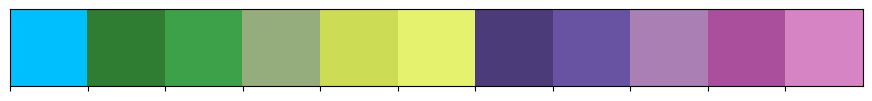

In [20]:
retrained_palette = sns.color_palette(config['retrained_color_palette'])
sns.palplot(retrained_palette)

# Create Figure 3 
if not os.path.exists(os.path.join(config["figures_folder"], "Figure3")):
    os.makedirs(os.path.join(config["figures_folder"], "Figure3"))

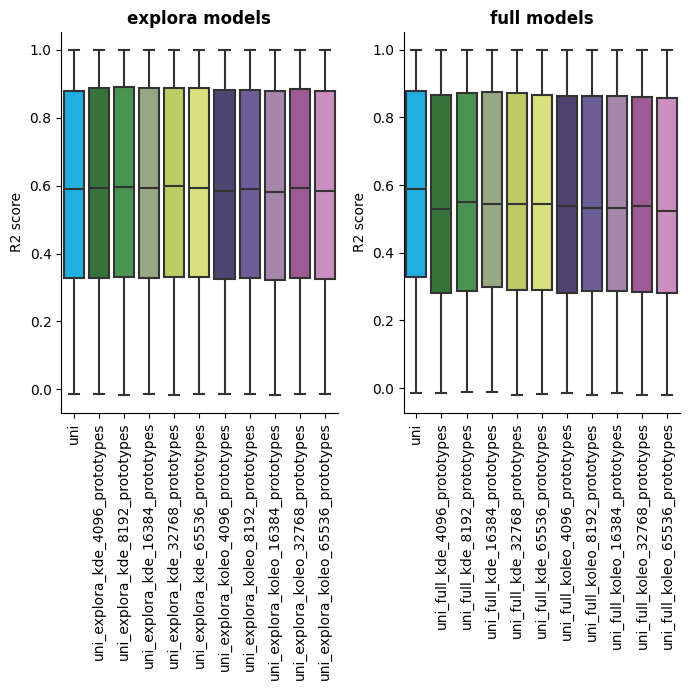

In [21]:

plt.figure(figsize=(7, 7))

i = 0
for model_type, names, benchmark_folder in zip([config['retrained_model_list1_type'],
                                    config['retrained_model_list2_type']], 
                                    [config['retrained_model_list1'],
                                      config['retrained_model_list2']],
                                      [config['retrained_benchmark_folder1'],
                                       config['retrained_benchmark_folder2']]):
    plt.subplot(1, 2, i+1)

    dfs = []
    for model_name in names:
        # names.append(file)

        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression/linear", model_name, 'r2_scores.csv'), index_col=0))

    df = pd.concat(dfs, axis=1)
    df.columns = names

    sns.boxplot(data=df, palette=retrained_palette, showfliers=False)
    sns.despine()
    plt.xticks(rotation=90);
    plt.title(f"{model_type} models", weight='bold')
    plt.ylabel("R2 score")
    i += 1
plt.savefig(os.path.join(config['figures_folder'], "Figure3/handcrafted_features_r2_boxplots.pdf"), bbox_inches='tight')


plt.tight_layout()

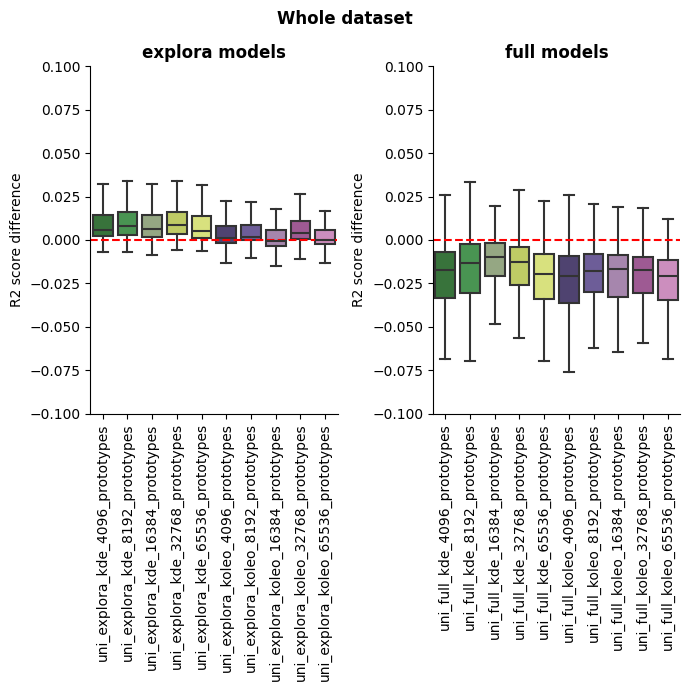

In [30]:

plt.figure(figsize=(7, 7))
i = 0
for model_type, names, benchmark_folder in zip([config['retrained_model_list1_type'],
                                    config['retrained_model_list2_type']], 
                                    [config['retrained_model_list1'],
                                      config['retrained_model_list2']],
                                      [config['retrained_benchmark_folder1'],
                                       config['retrained_benchmark_folder2']]):
    plt.subplot(1, 2, i+1)

    dfs = []
    
    for model_name in names:
        # names.append(file)

        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression", "linear", model_name, 'r2_scores.csv'), index_col=0))

    df = pd.concat(dfs, axis=1)
    df.columns = names

    df_diff = df.apply(lambda x: x - df['uni'], axis=0)
    df_diff.drop('uni', axis=1, inplace=True)

    sns.boxplot(data=df_diff, palette=retrained_palette[1:], showfliers=False)
    sns.despine()
    plt.xticks(rotation=90);
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{model_type} models", weight='bold')
    plt.ylim(-0.1, 0.1)
    plt.ylabel("R2 score difference")
    i += 1
plt.tight_layout()
plt.suptitle("Whole dataset", weight='bold')
plt.savefig(os.path.join(config['figures_folder'], "Figure3/handcrafted_features_r2_diff_boxplots.pdf"), bbox_inches='tight')

plt.tight_layout()



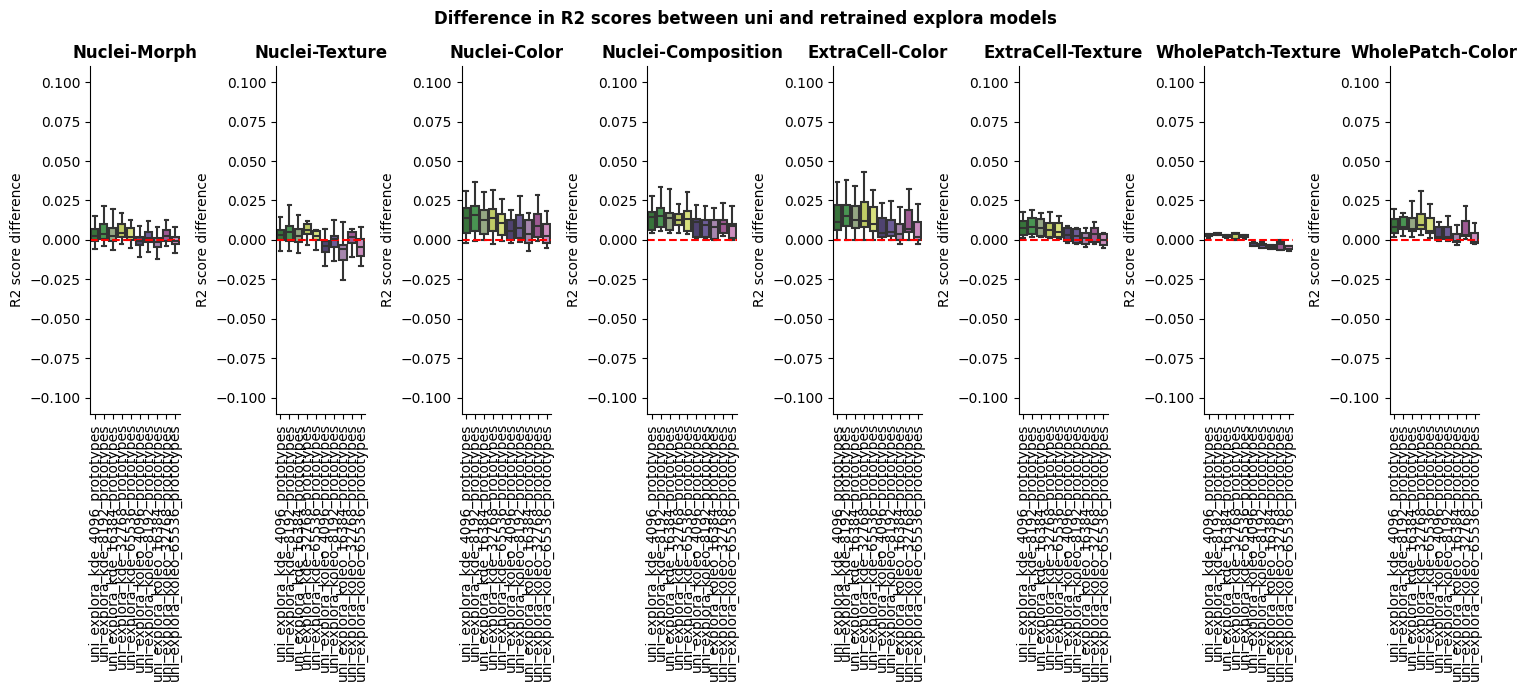

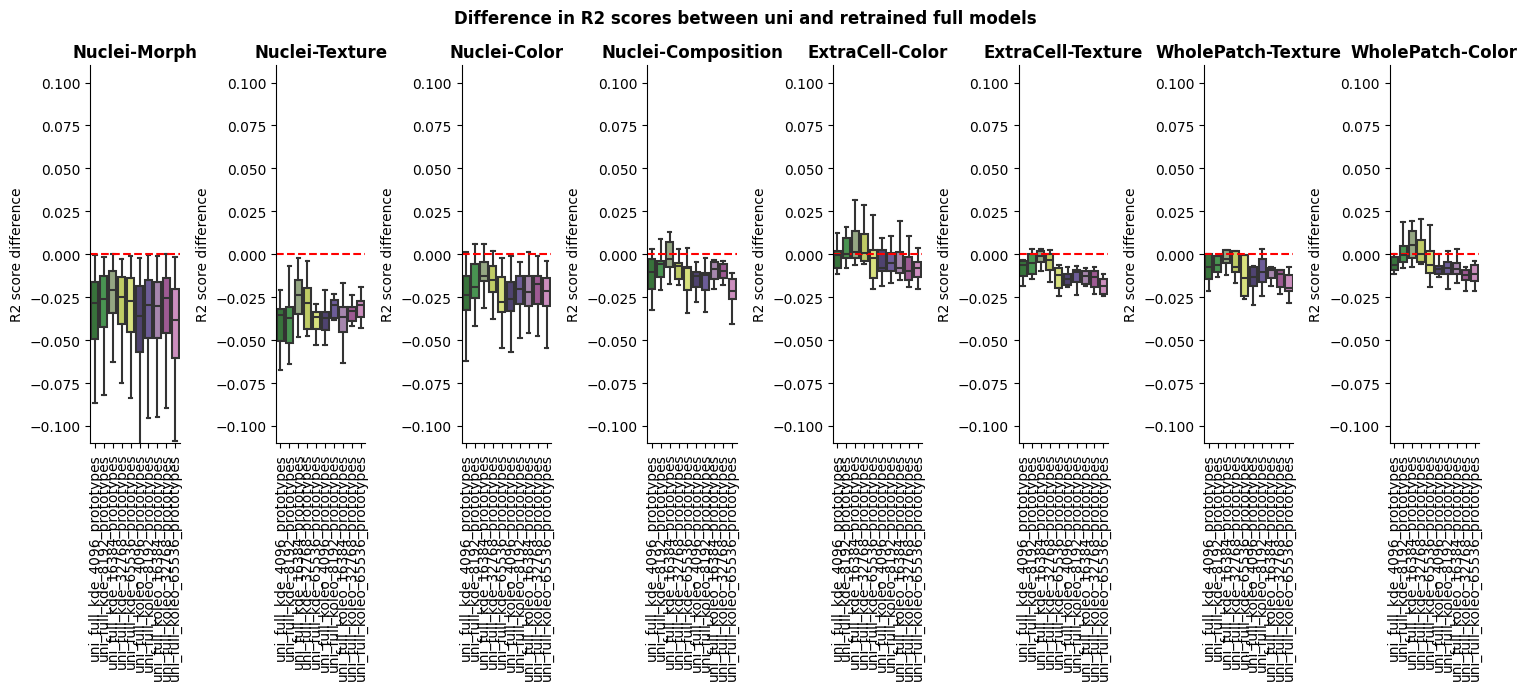

In [40]:

for model_type, names, benchmark_folder in zip([config['retrained_model_list1_type'],
                                    config['retrained_model_list2_type']], 
                                    [config['retrained_model_list1'],
                                      config['retrained_model_list2']],
                                      [config['retrained_benchmark_folder1'],
                                       config['retrained_benchmark_folder2']]):
    #plt.subplot(1, 2, i+1)

    dfs = []
    for model_name in names:
        # names.append(file)

        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression", "linear", model_name, 'r2_scores.csv'), index_col=0))

    df = pd.concat(dfs, axis=1)
    df.columns = names

    df_diff = df.apply(lambda x: x - df['uni'], axis=0)
    df_diff.drop('uni', axis=1, inplace=True)

    feature_types = list(set([idx.split("_")[0] for idx in df_diff.index]))
    feature_types_order = df_melted['feature_type'].unique()
    plt.figure(figsize=(15, 7))
    for j, feature_type in enumerate(feature_types_order):
        plt.subplot(1, len(feature_types), j+1)
        idxs = [idx for idx in df_diff.index if idx.startswith(feature_type)]
        sns.boxplot(data=df_diff.loc[idxs], palette=retrained_palette[1:], showfliers=False)
        plt.xticks(rotation=90)
        plt.title(f"{feature_type}", weight='bold')
        plt.ylabel("R2 score difference")
        sns.despine()
        if model_type == "full":
            plt.ylim(-0.11, 0.12)
        else:

            plt.ylim(-0.05, 0.05)
        plt.ylim(-0.11, 0.11)
        plt.axhline(0, color='red', linestyle='--')
    #i += 1
    plt.suptitle(f"Difference in R2 scores between uni and retrained {model_type} models", weight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config["figures_folder"], f"Figure3/handcrafted_features_r2_diff_{model_type}_vs_uni_per_feature.pdf"), bbox_inches='tight')

## Retrained models -- on invasive cancer only

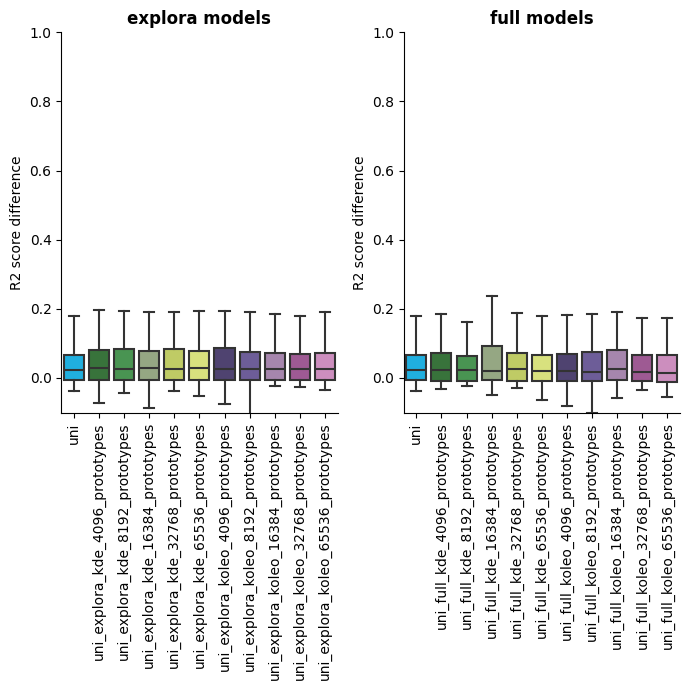

In [41]:
plt.figure(figsize=(7, 7))
i = 0
for model_type, names, benchmark_folder in zip([config['retrained_model_list1_type'],
                                    config['retrained_model_list2_type']], 
                                    [config['retrained_model_list1'],
                                      config['retrained_model_list2']],
                                      [config['retrained_benchmark_folder1'],
                                       config['retrained_benchmark_folder2']]):
    plt.subplot(1, 2, i+1)

    dfs = []
    for model_name in names:
        # names.append(file)

        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression", "linear", "invasive", model_name, 'r2_scores.csv'), index_col=0))

    df = pd.concat(dfs, axis=1)
    df.columns = names

    sns.boxplot(data=df, palette=retrained_palette, showfliers=False)
    sns.despine()
    plt.xticks(rotation=90);
    plt.title(f"{model_type} models", weight='bold')
    plt.ylabel("R2 score difference")
    plt.ylim(-0.1, 1)
    i = i + 1

plt.tight_layout()
plt.savefig(os.path.join(config["figures_folder"], "Figure3/handcrafted_features_r2_boxplots_invasive.pdf"), bbox_inches='tight')

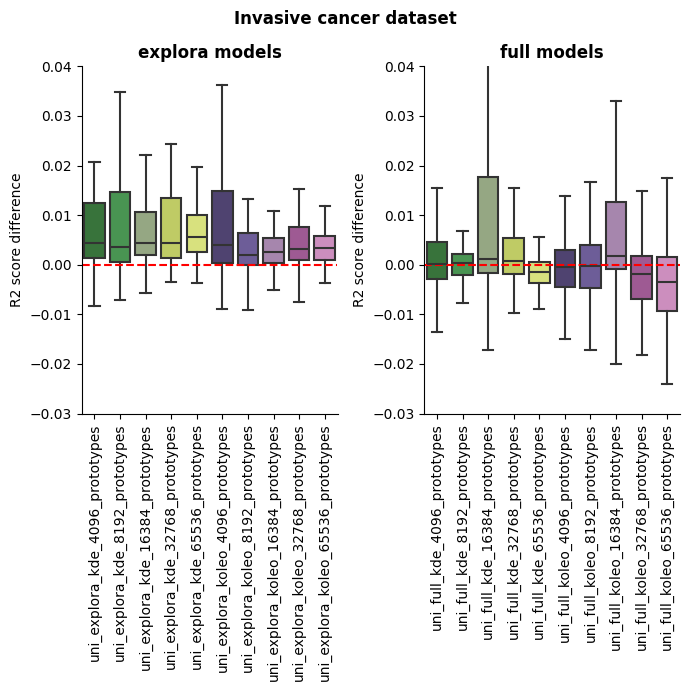

In [42]:
plt.figure(figsize=(7, 7))
i = 0
for model_type, names, benchmark_folder in zip([config['retrained_model_list1_type'],
                                    config['retrained_model_list2_type']], 
                                    [config['retrained_model_list1'],
                                      config['retrained_model_list2']],
                                      [config['retrained_benchmark_folder1'],
                                       config['retrained_benchmark_folder2']]):
    plt.subplot(1, 2, i+1)

    dfs = []
    for model_name in names:
        # names.append(file)

        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression", "linear", "invasive", model_name, 'r2_scores.csv'), index_col=0))

    df = pd.concat(dfs, axis=1)
    df.columns = names

    df_diff = df.apply(lambda x: x - df['uni'], axis=0)
    df_diff.drop('uni', axis=1, inplace=True)

    sns.boxplot(data=df_diff, palette=retrained_palette[1:], showfliers=False)
    sns.despine()
    plt.xticks(rotation=90);
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{model_type} models", weight='bold')
    plt.ylim(-0.03, 0.04)
    plt.ylabel("R2 score difference")
    i = i + 1

plt.suptitle("Invasive cancer dataset", weight='bold')

plt.tight_layout()
plt.savefig(os.path.join(config["figures_folder"], "Figure3/handcrafted_features_r2_diff_boxplots_invasive.pdf"), bbox_inches='tight')

In [43]:
feature_types

['ExtraCell-Texture',
 'WholePatch-Texture',
 'Nuclei-Composition',
 'ExtraCell-Color',
 'Nuclei-Texture',
 'Nuclei-Morph',
 'Nuclei-Color',
 'WholePatch-Color']

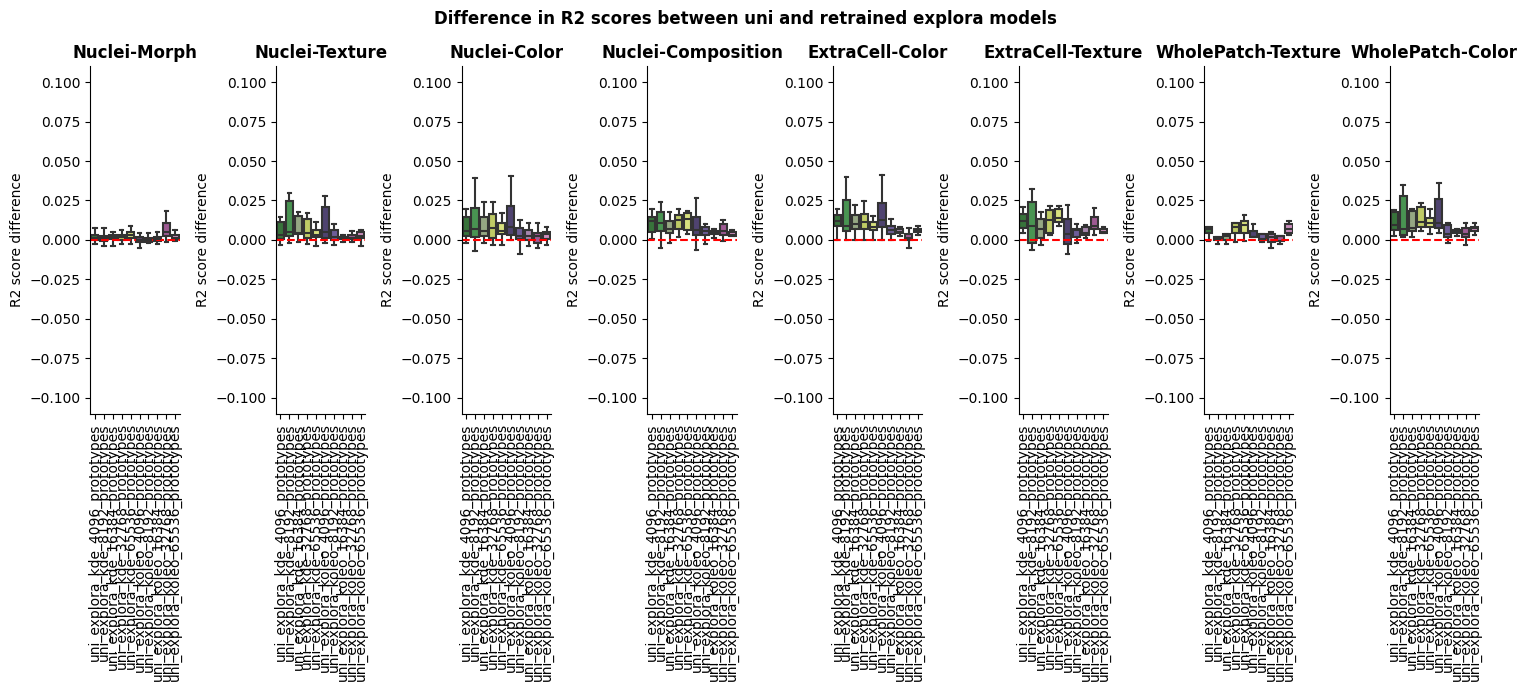

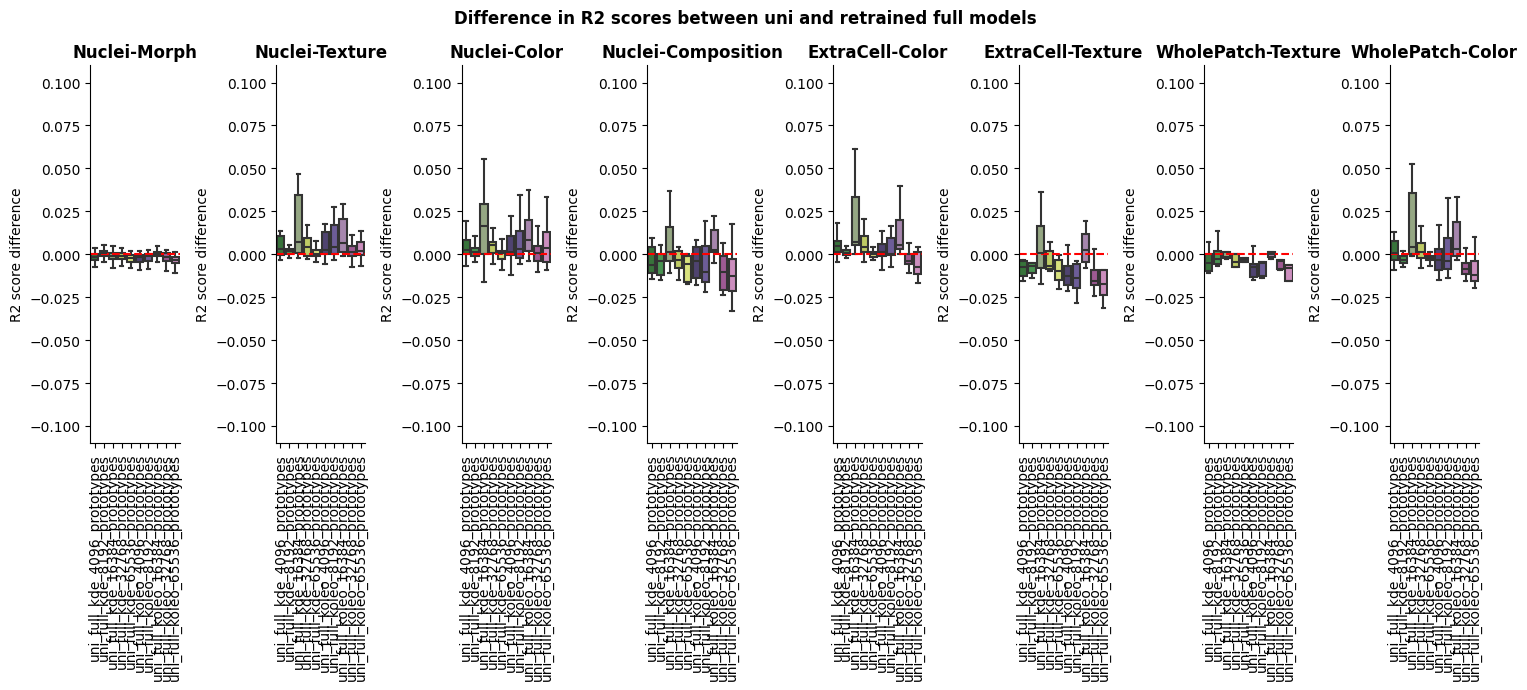

In [46]:
for model_type, names, benchmark_folder in zip([config['retrained_model_list1_type'],
                                    config['retrained_model_list2_type']], 
                                    [config['retrained_model_list1'],
                                      config['retrained_model_list2']],
                                      [config['retrained_benchmark_folder1'],
                                       config['retrained_benchmark_folder2']]):

    dfs = []

    
    for model_name in names:
        # names.append(file)

        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression", "linear", "invasive", model_name, 'r2_scores.csv'), index_col=0))

    df = pd.concat(dfs, axis=1)
    df.columns = names

    df_diff = df.apply(lambda x: x - df['uni'], axis=0)
    df_diff.drop('uni', axis=1, inplace=True)

    #feature_types = list(set([idx.split("_")[0] for idx in df_diff.index]))
    
    plt.figure(figsize=(15, 7))
    for j, feature_type in enumerate(feature_types_order):
        plt.subplot(1, len(feature_types), j+1)
        idxs = [idx for idx in df_diff.index if idx.startswith(feature_type)]
        sns.boxplot(data=df_diff.loc[idxs], palette=retrained_palette[1:], showfliers=False)
        plt.xticks(rotation=90)
        plt.title(f"{feature_type}", weight='bold')
        plt.ylabel("R2 score difference")
        sns.despine()
        if model_type == "full":
            plt.ylim(-0.05, 0.05)
        else:

            plt.ylim(-0.05, 0.05)
            
        plt.ylim(-0.11, 0.11)
        plt.axhline(0, color='red', linestyle='--')
    plt.suptitle(f"Difference in R2 scores between uni and retrained {model_type} models", weight='bold')
    plt.tight_layout()
    
plt.savefig(os.path.join(config["figures_folder"], f"Figure3/handcrafted_features_r2_diff_{model_type}_vs_uni_per_feature_invasive.pdf"), bbox_inches='tight')